## Import Packages

In [0]:
# for data analysis
import pandas as pd

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# for spark
from pyspark.sql import SparkSession

## Connect to S3

In [0]:
access_key = '...'
secret_key = '...'
encoded_secret_key = secret_key.replace("/", "%2F")
aws_bucket_name = "amazon-review-hj"
mount_name = "s3dataread"

## Read Data from S3

In [0]:
# Create a Spark session
spark = SparkSession.builder.appName("ReadS3Files").getOrCreate()

# Specify the S3 folder path
s3_folder_path = "dbfs:/mnt/s3dataread/landing/"

# List all files in the S3 folder
files = dbutils.fs.ls(s3_folder_path)

# Store file names and locations
file_name = []
file_path = []
for file in files:
    file_name.append(file.name)
    file_path.append(file.path)

In [0]:
file_name

['amazon_reviews_us_Apparel_v1_00.tsv',
 'amazon_reviews_us_Automotive_v1_00.tsv',
 'amazon_reviews_us_Books_v1_02.tsv',
 'amazon_reviews_us_Camera_v1_00.tsv',
 'amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv',
 'amazon_reviews_us_Electronics_v1_00.tsv',
 'mini_df.csv/',
 'mini_df.tsv/']

In [0]:
file_path

['dbfs:/mnt/s3dataread/landing/amazon_reviews_us_Apparel_v1_00.tsv',
 'dbfs:/mnt/s3dataread/landing/amazon_reviews_us_Automotive_v1_00.tsv',
 'dbfs:/mnt/s3dataread/landing/amazon_reviews_us_Books_v1_02.tsv',
 'dbfs:/mnt/s3dataread/landing/amazon_reviews_us_Camera_v1_00.tsv',
 'dbfs:/mnt/s3dataread/landing/amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv',
 'dbfs:/mnt/s3dataread/landing/amazon_reviews_us_Electronics_v1_00.tsv',
 'dbfs:/mnt/s3dataread/landing/mini_df.csv/',
 'dbfs:/mnt/s3dataread/landing/mini_df.tsv/']

In [0]:
from pyspark.sql import SparkSession
from functools import reduce

# Create a Spark session
spark = SparkSession.builder.appName("example").getOrCreate()

# Read the first file
df = spark.read.csv(file_path[0], sep='\t', inferSchema=True, header=True)

# Vertically merge all other files
for path in file_path[1:6]:
    new_file = spark.read.csv(path, sep='\t', inferSchema=True, header=True)
    df = df.union(new_file)

In [0]:
pyspark_df = df

In [0]:
from pyspark.sql.functions import rand
python_df = df.orderBy(rand(seed=42)).limit(5000).toPandas()

## EDA using Python

In [0]:
python_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   marketplace               5000 non-null   object
 1   customer_id               5000 non-null   int32 
 2   review_id                 5000 non-null   object
 3   product_id                5000 non-null   object
 4   product_parent            5000 non-null   int32 
 5   product_title             5000 non-null   object
 6   product_category          5000 non-null   object
 7   star_rating               5000 non-null   int32 
 8   helpful_votes             5000 non-null   int32 
 9   total_votes               5000 non-null   int32 
 10  vine                      5000 non-null   object
 11  verified_purchase         5000 non-null   object
 12  review_headline           5000 non-null   object
 13  review_body               5000 non-null   object
 14  review_date             

In [0]:
python_df.isnull().sum()

marketplace                 0
customer_id                 0
review_id                   0
product_id                  0
product_parent              0
product_title               0
product_category            0
star_rating                 0
helpful_votes               0
total_votes                 0
vine                        0
verified_purchase           0
review_headline             0
review_body                 0
review_date                 0
product_title_word_count    0
review_headline_count       0
review_body_count           0
dtype: int64

In [0]:
python_df.dropna(inplace = True)

In [0]:
python_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,product_title_word_count,review_headline_count,review_body_count
0,US,10299853,R3I2KDWH5TGA2W,B006TQNPQ0,300577506,Irish Goodbye [Explicit],Digital_Music_Purchase,5,0,0,N,Y,Completely real and from the heart as (I belie...,Completely real and from the heart as (I belie...,2014-11-11,3,11,11
1,US,52306464,R25I633R6CBPKW,0785114440,977250152,District X Vol. 1: Mr. M (X-Men),Books,5,1,3,N,N,District X: X marks the spot!,"An amazing combination of brilliant, convincin...",2005-03-13,7,6,6
2,US,10109500,R8H6SI5Q23WDI,B00MTPUAS6,923245018,Sexy Women‘s Brazilian Bikini Bottoms Back wit...,Apparel,5,0,0,N,Y,I really think they're adorable. I read the ot...,Just got these today and before the estimated ...,2015-05-14,8,14,14
3,US,13606007,R3OTHFROISE55E,B004BTFPGK,52637796,Quality Chain Cobra Cable Passenger Snow Tract...,Automotive,3,20,25,N,Y,Photo is misleading,Unsure if the chains are good or not (haven't ...,2011-12-29,9,3,3
4,US,45590555,R1G0IW898OJOOJ,B00EQO0AIS,124657201,Love and War,Digital_Music_Purchase,5,0,0,N,Y,Tamar Wins,"Love this album, her voice is everything and j...",2013-09-05,3,2,2


In [0]:
python_df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,product_title_word_count,review_headline_count,review_body_count
count,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2.950060e+07,5.045317e+08,4.181000,2.753400,3.498200,9.114200,4.231000,4.231000
std,1.641186e+07,2.908080e+08,1.261332,18.871826,20.183584,6.014083,3.215168,3.215168
min,5.822500e+04,8.742900e+04,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.461747e+07,2.507557e+08,4.000000,0.000000,0.000000,5.000000,2.000000,2.000000
50%,2.959812e+07,5.042149e+08,5.000000,0.000000,0.000000,8.000000,3.000000,3.000000
75%,4.521150e+07,7.602333e+08,5.000000,1.000000,2.000000,11.000000,6.000000,6.000000
max,5.309640e+07,9.999687e+08,5.000000,1067.000000,1094.000000,82.000000,23.000000,23.000000


In [0]:
# Convert to correct data type
python_df['review_date'] =  pd.to_datetime(python_df['review_date'])

# Get date range
print('Min Date:', python_df['review_date'].min())
print('Max Date:', python_df['review_date'].max())

Min Date: 1997-01-05 00:00:00
Max Date: 2015-08-31 00:00:00


In [0]:
# Create new columns for word count
python_df['product_title_word_count'] = python_df['product_title'].str.split().apply(len)
python_df['review_headline_count'] = python_df['review_headline'].str.split().apply(len)
python_df['review_body_count'] = python_df['review_headline'].str.split().apply(len)
word_count = python_df.iloc[:, -3:]

In [0]:
word_count.describe()

,product_title_word_count,review_headline_count,review_body_count
count,5000.000000,5000.000000,5000.000000
mean,9.114200,4.231000,4.231000
std,6.014083,3.215168,3.215168
min,1.000000,1.000000,1.000000
25%,5.000000,2.000000,2.000000
50%,8.000000,3.000000,3.000000
75%,11.000000,6.000000,6.000000
max,82.000000,23.000000,23.000000


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

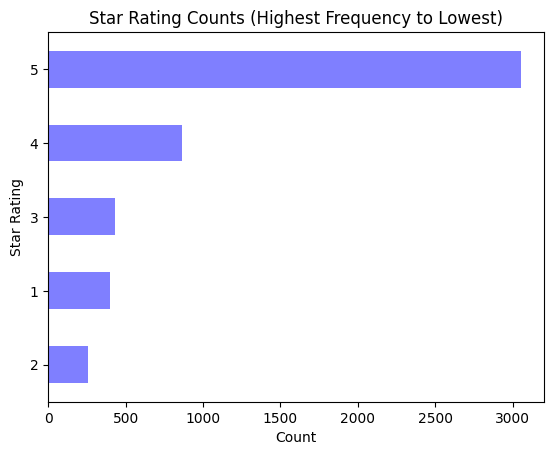

In [0]:
# Calculate value counts
value_counts = python_df['star_rating'].value_counts()

# Sort the value counts by frequency in descending order
sorted_value_counts = value_counts.sort_values(ascending=True)

# Create a horizontal bar plot
sorted_value_counts.plot.barh(color="blue", alpha=0.5)

# Edit visualization
plt.xlabel('Count')
plt.ylabel('Star Rating')
plt.title('Star Rating Counts (Highest Frequency to Lowest)')
plt.show()

## Data Cleaning with PySpark

In [0]:
pyspark_df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)



In [0]:
# Get the number of rows
num_rows = pyspark_df.count()

# Get the number of columns
num_columns = len(pyspark_df.columns)

# Print the shape
print("Number of Rows: {}".format(num_rows))
print("Number of Columns: {}".format(num_columns))

Number of Rows: 19111522
Number of Columns: 15


In [0]:
# Remove unnecessary columns
selected_columns = ['verified_purchase','product_category','review_headline', 'review_body', 'star_rating', 'review_date']
pyspark_df = pyspark_df.select(*selected_columns)
display(pyspark_df.show(10))

+-----------------+----------------+--------------------+--------------------+-----------+-----------+
|verified_purchase|product_category|     review_headline|         review_body|star_rating|review_date|
+-----------------+----------------+--------------------+--------------------+-----------+-----------+
|                Y|         Apparel|★ THESE REALLY DO...|These Really Do W...|          4| 2013-01-14|
|                Y|         Apparel|Favorite for wint...|I love this dress...|          5| 2014-03-04|
|                Y|         Apparel|Great Socks for t...|Nice socks, great...|          5| 2015-07-12|
|                Y|         Apparel|          Slick hat!|I bought this for...|          5| 2015-06-03|
|                Y|         Apparel|I would do it again!|Perfect dress and...|          5| 2015-06-12|
|                Y|         Apparel|          Five Stars|Excellent for my ...|          5| 2014-04-22|
|                Y|         Apparel|            Love it!|Raw is the only 

In [0]:
# Drop rows with any missing values
pyspark_df = pyspark_df.dropna()

In [0]:
# Repartition the DataFrame before writing to Parquet
pyspark_df_repartitioned = pyspark_df.repartition(4)  # Specify the number of partitions

# Write the repartitioned DataFrame to Parquet
pyspark_df_repartitioned.write.mode("overwrite").parquet('dbfs:/mnt/s3dataread/raw/df_cleaned_repartitioned.parquet')

In [0]:
1+1

2

In [0]:
1+1

2

In [0]:
1+1

2